In [1]:
# import statements for all used packages
import matplotlib
from IPython.display import display
from matplotlib import pyplot as plt
from matplotlib.ticker import FormatStrFormatter
plt.rcParams['figure.figsize'] = [18, 20]
from pprint import pprint
from scipy.optimize import minimize, Bounds, LinearConstraint, fsolve
import numpy as np
import copy
import matplotlib.gridspec as gridspec
import seaborn as sns; sns.set()
import pandas as pd
import time as time_lib
import os
from gurobipy import GRB, Model, quicksum

# Helper Classes and Functions

In [2]:
# chooses optimal random probabilities to optimize costs
def randFunc(alpha):
    if extra_edge:
        alpha = list(alpha)
#         alpha.append(alpha[0])
    else:
        alpha = [1] + list(alpha)
    grad = [-c[j]*lamb[j]*mu[2*j]/(alpha[j]*(mu[2*j])+(1-alpha[j+1])*mu[2*(j+1)-1]-lamb[j])**2 + -c[j-1]*lamb[j-1]*-mu[2*j-1]/(alpha[j-1]*mu[2*(j-1)]+(1-alpha[j])*mu[2*j-1]-lamb[j-1])**2 for j in range(1 - extra_edge, n-1)]
    if extra_edge:
        grad += [-c[(n-1)]*lamb[(n-1)]*mu[2*(n-1)]/(alpha[(n-1)]*(mu[2*(n-1)])+(1-alpha[0])*mu[2*((n-1)+1)-1]-lamb[(n-1)])**2 + -c[(n-1)-1]*lamb[(n-1)-1]*-mu[2*(n-1)-1]/(alpha[(n-1)-1]*mu[2*((n-1)-1)]+(1-alpha[(n-1)])*mu[2*(n-1)-1]-lamb[(n-1)-1])**2]
    else:
        grad += [-c[n-1]*lamb[n-1]*mu[2*(n-1)]/(alpha[n-1]*(mu[2*(n-1)])-lamb[n-1])**2 + -c[(n-1)-1]*lamb[(n-1)-1]*-mu[2*(n-1)-1]/(alpha[(n-1)-1]*mu[2*((n-1)-1)]+(1-alpha[n-1])*mu[2*(n-1)-1]-lamb[(n-1)-1])**2]

    
    
    return grad

# uses KKT conditions to solve for Best Random probabilities
def randOptimize():
    init = [1 for j in range(n)] #+ [1]
    if not extra_edge:
        for j in range(1, n):
            ub = min([1, (mu[2*(j-1)] - lamb[j-1] + init[j-1]*mu[2*(j-1)])/ mu[2*j-1]])
            init[j] = ub
        for j in range(n-1, 0, -1):
            if j == n-1:
                lb = lamb[j] / mu[2*j]
            else:
                lb = max([0, (-(1-init[j+1])*mu[2*(j+1)-1] + lamb[j])/mu[2*j]])
            init[j] = (init[j] + lb)/2
        init = init[1:]
    
    root = fsolve(randFunc, init) #, method='trust-constr', options={'disp': False, 'xtol':1e-40,}, bounds=bounds, constraints=[denom_constr]) # 'xtol':1e-13,  , xtol=1e-25   , factor = 1e-6
    if not extra_edge:
        root = [1] + list(root)
    
#     objective = lambda alpha: sum([c[j]*lamb[j]/(alpha[j]*mu[2*j]+(1-alpha[j+1])*mu[2*(j+1)-1]-lamb[j]) for j in range(n-1)]) + c[n-1]*lamb[n-1]/(alpha[n-1]*mu[2*(n-1)] - lamb[n-1])
    results = root
    if not extra_edge:
        for j in range(1, n):
            ub = min([1, (mu[2*(j-1)] - lamb[j-1] + results[j-1]*mu[2*(j-1)])/ mu[2*j-1]])
            if results[j] > ub:
                results[j] = ub
        for j in range(n-1, 0, -1):
            if j == n-1:
                lb = lamb[j] / mu[2*j]
            else:
                lb = max([0, (-(1-results[j+1])*mu[2*(j+1)-1] + lamb[j])/mu[2*j]])
            if results[j] < lb:
                results[j] = lb
    print(results)
    return(results)

# color map for joint plots
afmhot = matplotlib.cm.get_cmap('afmhot', 512)
newcolors = afmhot(np.linspace(0, 1, 512))
bg = np.array([200/256, 220/256, 250/256, 1])
newcolors[:1, :] = bg
afmhot_with0 = matplotlib.colors.ListedColormap(newcolors)

# Input Parameters

In [6]:
extra_edge = False
ns = [3] # number of servers/buffers
mu = [1 for i in range(2*max(ns)-1 + extra_edge)] # service rates per server
duration = 5*10**5 # number of events (cont) or time units (disc)
epsilons = [0.005] # extent to which the system is in heavy traffic [0.1, 0.05, 0.01, 0.005, 0.001]
c = []#DEFINE LATER ##list(range(1, 20)) #if max(ns)==2 else np.random.randint(5, 15, size=max(ns)) # random costs per buffer, comment out if keeping costs between algs
time_mode = "continuous"
out_folder = "Output\\N-Systems" # base folder
#"C:\\Users\\Adam\\Dropbox\\REU 2021 Shared Folder\\Adam\\Code\\Output\\N-Systems"
additional_info = "" # info to write to the run log # distribution of q0 and q1-q0
lamb_defined = False                                 if max(ns)==2 else True # set all lambda equal to 1-(epsilon/n)?
ordered_costs = True # sort costs? will try ascending and descending
warmup_period = 0.4 # proportion of duration to cut off
graph = False # create graphs? very taxing on memory
graph_dist = True
to_folder = True
show_output = True # print output in Jupyter Notebook?



# don't change most of this, it mostly cleans up the inputs above
directions = sorted(["crp_tri", "crp_rect", "noncrp_tri", "noncrp_rect"]) if not lamb_defined else [1]
algs = ["maxweight", "weighted_maxweight", "cmu", "cmu_thresh", "random", "random_idle"]#["maxweight", "weighted_maxweight", "cmu", "cmu_thresh", "random", "random_idle"] # ["maxweight", "weighted_maxweight", "cmu", "cmu_single_thresh", "cmu_multi_thresh", "random", "prioritize_right", "threshold", "random_idle"]
num_algs = len(algs)
color_dict = {i:color for (i, color) in enumerate([f"C{i}" for i in range(10)])}
# maxweight params
# gamma = [1 for j in range(n)] # "cost"
beta = 1

input_params = {"mu":mu, "duration":duration, "warmup proportion":warmup_period, "cost vect":c, "beta":beta, "time":time_mode,
                "lamb = 1-epsilon/n":lamb_defined, "random cost order":(not ordered_costs), "additional info":additional_info} # "gamma":gamma, 

# Simulation

Good Case: Queue 0 is least expensive.
[1, 1, 1, 1]
Progress: 10%
Progress: 20%
Progress: 30%
Progress: 40%
Progress: 50%
Progress: 60%
Progress: 70%
Progress: 80%
Progress: 90%


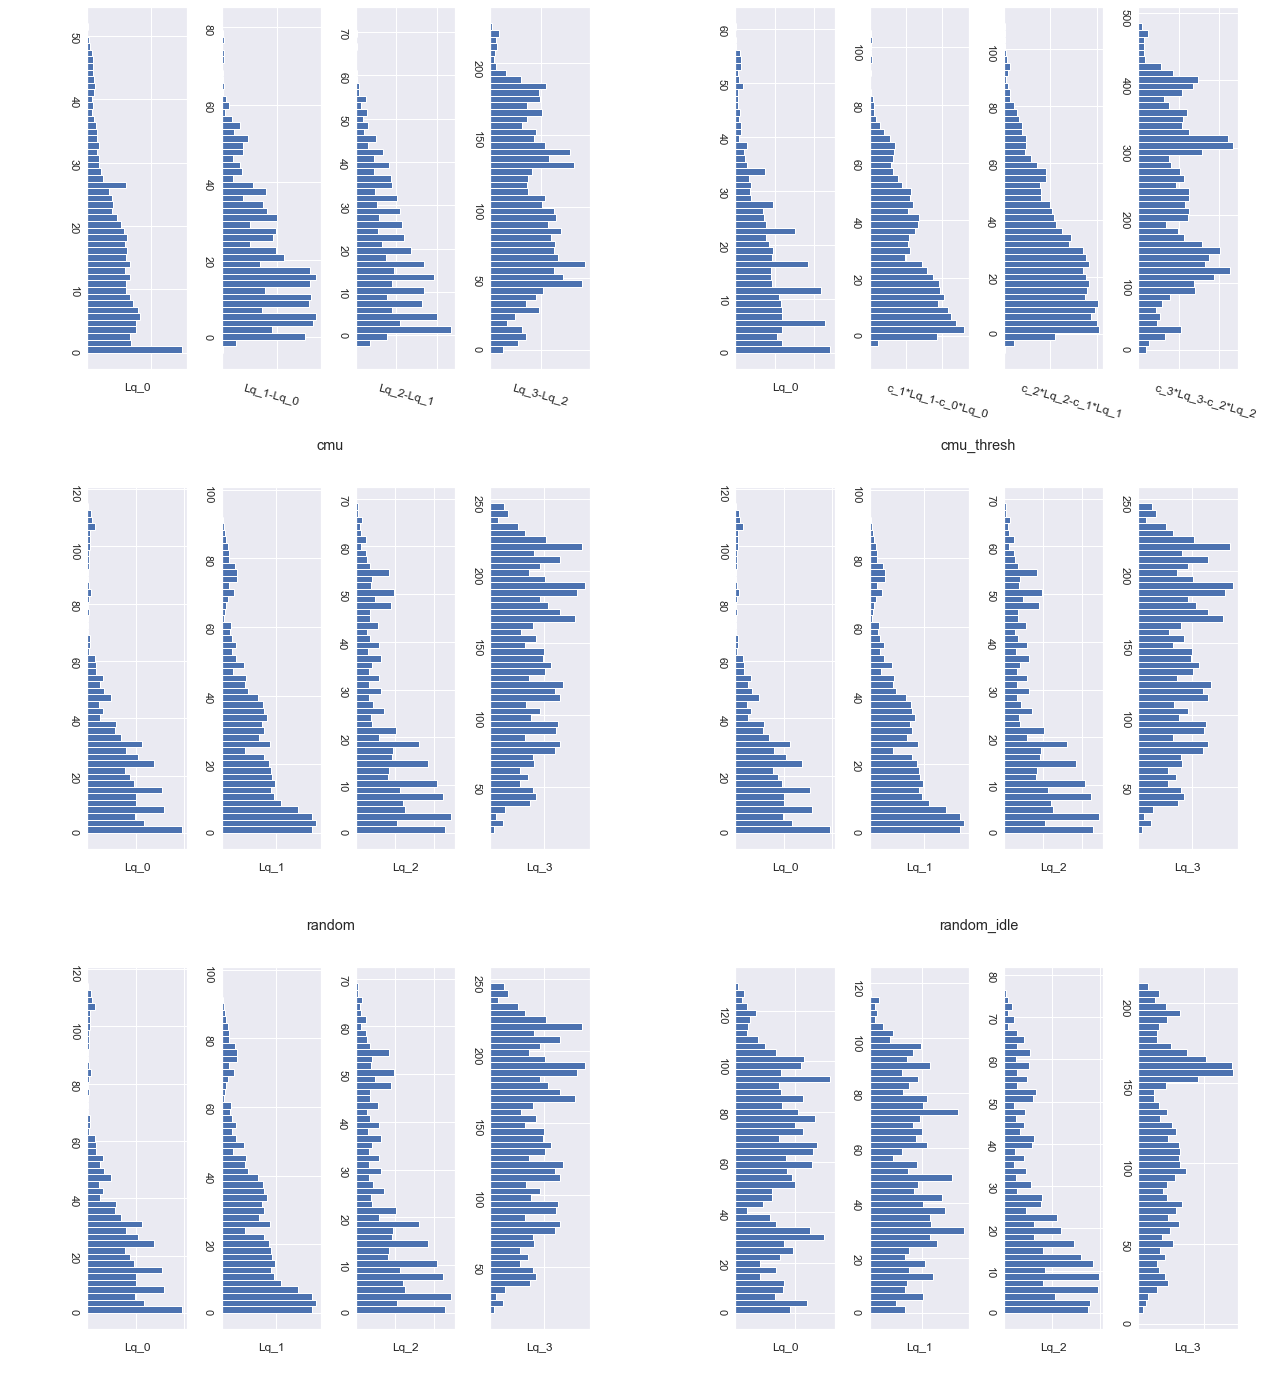





  Graph Index Direction epsilon  Case           Algorithm lambda_0 lambda_1  \
0           0       NaN   0.005  good           maxweight    0.995    0.995   
1           0       NaN   0.005  good  weighted_maxweight    0.995    0.995   
2           0       NaN   0.005  good                 cmu    0.995    0.995   
3           0       NaN   0.005  good          cmu_thresh    0.995    0.995   
4           0       NaN   0.005  good              random    0.995    0.995   
5           0       NaN   0.005  good         random_idle    0.995    0.995   

  lambda_2 lambda_3 Queue 0 Param Queue 1 Param Queue 2 Param Queue 3 Param  \
0    0.995    0.995             1             1             1             1   
1    0.995    0.995           1.0      1.333333      1.666667           2.0   
2    0.995    0.995           NaN           NaN           NaN           NaN   
3    0.995    0.995           600           600           600           NaN   
4    0.995    0.995             1             1

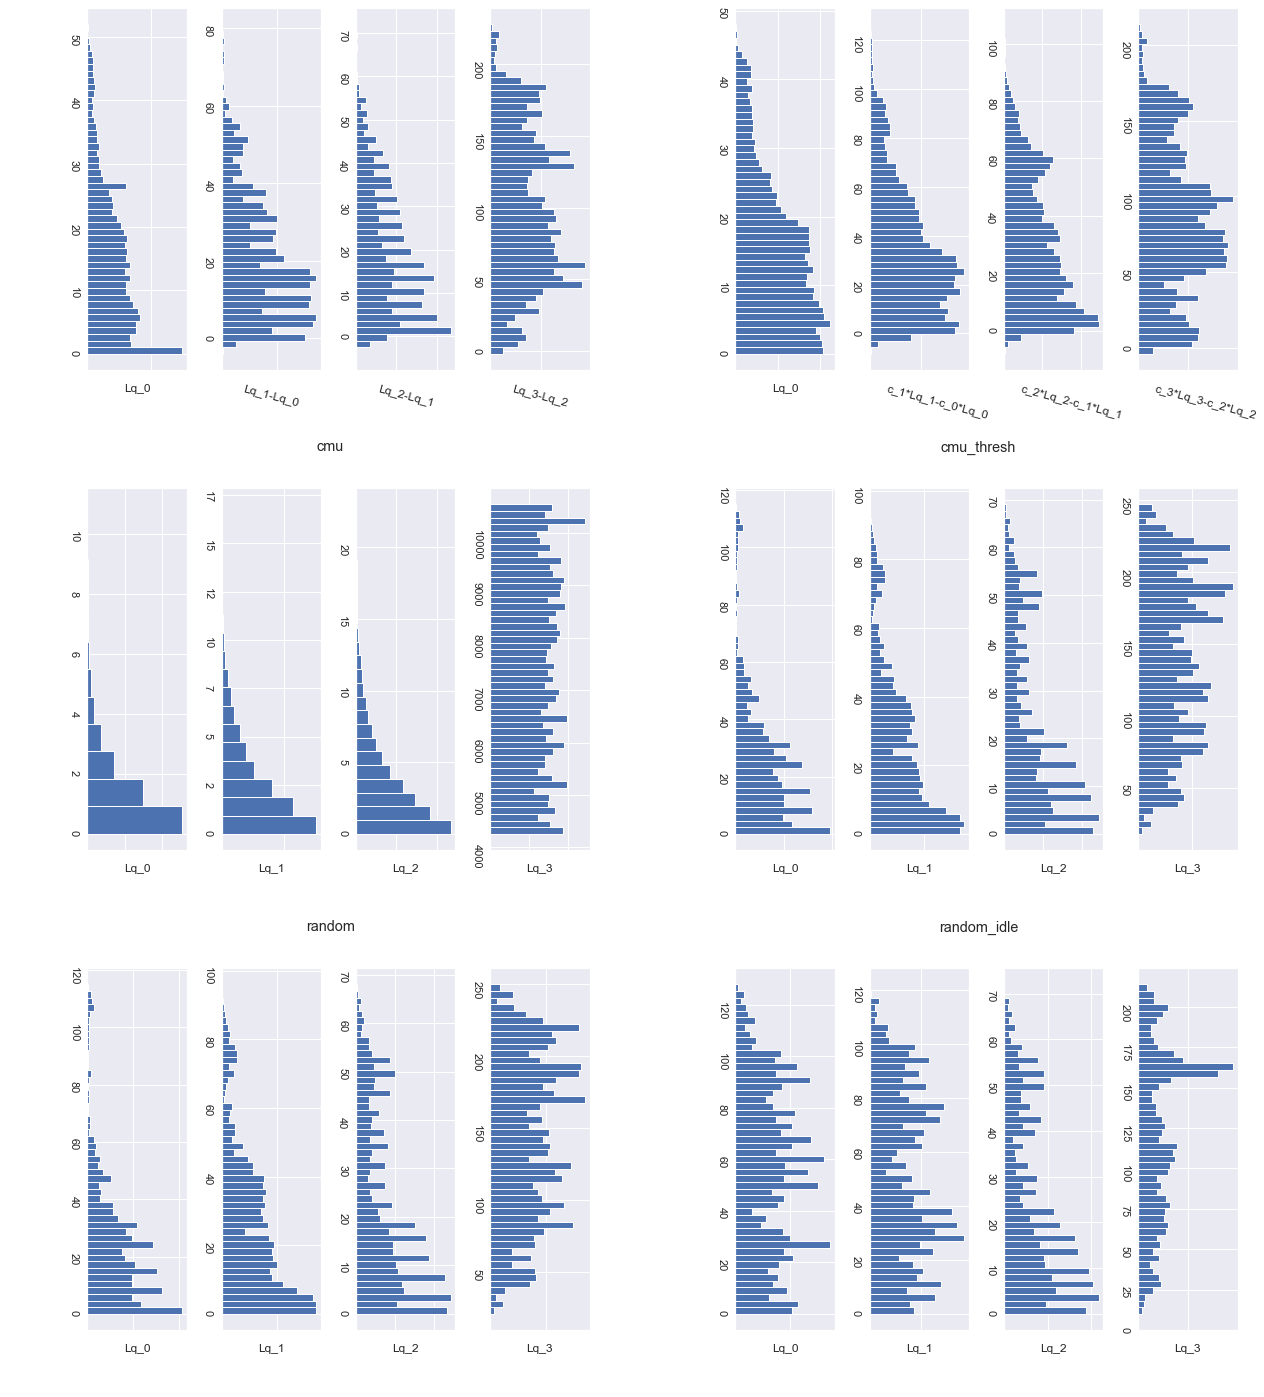





  Graph Index Direction epsilon Case           Algorithm lambda_0 lambda_1  \
0           1       NaN   0.005  bad           maxweight    0.995    0.995   
1           1       NaN   0.005  bad  weighted_maxweight    0.995    0.995   
2           1       NaN   0.005  bad                 cmu    0.995    0.995   
3           1       NaN   0.005  bad          cmu_thresh    0.995    0.995   
4           1       NaN   0.005  bad              random    0.995    0.995   
5           1       NaN   0.005  bad         random_idle    0.995    0.995   

  lambda_2 lambda_3 Queue 0 Param Queue 1 Param Queue 2 Param Queue 3 Param  \
0    0.995    0.995             1             1             1             1   
1    0.995    0.995           2.0      1.666667      1.333333           1.0   
2    0.995    0.995           NaN           NaN           NaN           NaN   
3    0.995    0.995           600           600           600           NaN   
4    0.995    0.995             1       0.99918      0

In [8]:
# creates info.txt to store important run info
out_time = int(time_lib.time())
out_i = 0
if to_folder:
    os.makedirs(f"{out_folder}\\{out_time}")
with open(f"{out_folder}\\{out_time}\\"*to_folder + "info.txt", "w") as file:
    for (label, data) in input_params.items():
        print(f"{label}:", data, file=file)
    
# iterate through system lengths  
for n in ns:

    # build cost vector evenly spread b/w 1 and 2
    c = list(np.linspace(1, 2, num=n))
    
    # iterate through good and bad case if applicable
    for case in range(1 + ordered_costs):
        if ordered_costs:
            c.sort()
            if case == 0:
                if show_output:
                    print("Good Case: Queue 0 is least expensive.")
            else:
                if show_output:
                    print("Bad Case: Queue 0 is most expensive.")
                c = c[::-1]
        
        # iterate through capacity region directions if applicable
        for direction in directions:
            lambdas = []
    
            # only if lambdas are not defined directly by epsilon
            if not lamb_defined:

                if n == 2:
                    fig = plt.figure(figsize=[10, 10])
                    # plot capacity region w/ lambdas approaching facets
                    plt.fill_between([0, mu[0]], 0, mu[2], color='C2', alpha=0.1)
                    plt.fill_between([mu[0], mu[0] + mu[1]], 0, [mu[2], 0], color='C2', alpha=0.1)
                    plt.axhline(mu[2], xmin=0, xmax=mu[0])
                    plt.axvline(mu[0], ymin=0, ymax=mu[2], linestyle="dashed")
                    plt.plot([0, mu[0]+mu[1]], [mu[2] + mu[0]*mu[2]/mu[1], 0])
                    plt.xlim([0, (mu[0]+mu[1])])
                    plt.ylim([0, (mu[2] + mu[0]*mu[2]/mu[1])])

                    # what direction do we approach heavy traffic limit
                    if direction == "noncrp_rect":
                        slope = mu[2] / mu[0]
                        for epsilon in epsilons:
                                lambdas.append((mu[0] * (1-epsilon/2), slope * mu[0] * (1-epsilon/2)))
                                plt.plot(lambdas[-1][0], lambdas[-1][1], marker="+")
                    if direction == "crp_tri":
                        slope = (mu[0]+mu[1]) / (mu[2] + mu[0]*mu[2]/mu[1])
                        intercept = mu[2]/2 - (mu[0]+mu[1]/2) * slope
                        for epsilon in epsilons:
                                lambdas.append((mu[0]+ mu[1] / 2 * (1-epsilon/2), intercept + slope * (mu[0]+mu[1]/2) * (1-epsilon/2)))
                                plt.plot(lambdas[-1][0], lambdas[-1][1], marker="+")
                    if direction == "crp_rect":
                        for epsilon in epsilons:
                                lambdas.append((3*mu[0]/4, mu[2] * (1-epsilon/10)))
                                plt.plot(lambdas[-1][0], lambdas[-1][1], marker="+")
                    if direction == "noncrp_tri":
                        for epsilon in epsilons:
                                lambdas.append((mu[0] + epsilon*2 * mu[1]/2, mu[2] * (1-epsilon*2)))
                                plt.plot(lambdas[-1][0], lambdas[-1][1], marker="+")

                    # fix and print plot
                    plt.xlabel("Buffer 0 Arrival Rate")
                    plt.ylabel("Buffer 1 Arrival Rate")
                    plt.title("Capacity Region")
                    plt.savefig(f"{out_folder}\\{out_time}\\"*to_folder + f"region_{direction}.png")
                    if show_output:
                        plt.show()
                        print("\n\n")
                
            # otherwise lambdas are defined by epsilon
            else:
                for epsilon in epsilons:
                    lambdas.append([1-epsilon for j in range(n)])

            for lamb in lambdas:
    #             if n == 2:
    #                 epsilon = abs((1-lamb[1]/mu[2]) - (lamb[0]-mu[0])/mu[1])
    #             else:
    #             epsilon = 1 - sum(lamb) / sum(mu[::2])
                if not lamb_defined:
                    epsilon = sum(mu[::2]) - sum(lamb)
                else:
                    epsilon = epsilons[lambdas.index(lamb)]


                # initializing variables
                if time_mode == "continuous":
                    rng1 = np.random.default_rng(100)
                    rng2 = np.random.default_rng(200)
                    rng3 = np.random.default_rng(300)
                elif time_mode == "discrete":
                    rng1 = [np.random.default_rng(100 + j) for j in range(n)]
                    rng2 = [np.random.default_rng(200 + act) for act in range(2*n-1)]
                    rng3 = np.random.default_rng(300)
                    unused_tallys = [[0 for j in range(n)] for alg_index in range(num_algs)]

                # for threshold algs
                Lr = [600 for j in range(n)]#[i*3 for i in np.linspace(78-8*(n-3), 200+35*(n-3), num=n-1)] #[500 for j in range(n-1)]#[c[j+1]/c[j] * 120 * np.log(1/epsilon) for j in range(n-1)] # used to be 75  [110, 330][lambdas.index(lamb)]
                # for best random alg
                alpha = randOptimize()
#                 alpha = [0 for j in range(n)]

                # initializing statistics
                if graph:
                    event_time_stats = [[] for alg_index in range(num_algs)]
                    Lq_stats = [[] for alg_index in range(num_algs)]
                if graph_dist and n == 2:
                    Lq_freqs = [{} for alg_index in range(num_algs)]
                elif graph_dist:
                    Lq_freqs = [[{} for j in range(n)] for alg_index in range(num_algs)]
                decisions = [[1 for i in range(n)] for alg_index in range(num_algs)]
                Lqs = [[0 for i in range(n)] for alg_index in range(num_algs)]
                times = [0 for alg_index in range(num_algs)]
                Lq_tallys = [[0 for j in range(n)] for alg_index in range(num_algs)]
                

                # beginning run
                for iteration in range(duration):
                    if iteration % (duration // 10) == 0 and iteration > 0:
                        print(f"Progress: {(iteration // (duration // 10))*10}%")
                    if time_mode == "continuous":
                        # combining process rates
                        if extra_edge:
                            denominators = [sum(lamb) + (Lqs[alg_index][0] > 0 and decisions[alg_index][0] == 1) * mu[0] + (Lqs[alg_index][n-1] > 0 and decisions[alg_index][0] == 0) * mu[-1] + sum([(Lqs[alg_index][i] > 0 and decisions[alg_index][i+1] == 0) * mu[2*(i+1)-1] +
                                                (Lqs[alg_index][i+1] > 0 and decisions[alg_index][i+1] == 1) * mu[2*(i+1)] for i in range(n-1)]) for alg_index in range(num_algs)]
                        else:
                            denominators = [sum(lamb) + (Lqs[alg_index][0] > 0) * mu[0] + sum([(Lqs[alg_index][i] > 0 and decisions[alg_index][i+1] == 0) * mu[2*(i+1)-1] +
                                                (Lqs[alg_index][i+1] > 0 and decisions[alg_index][i+1] == 1) * mu[2*(i+1)] for i in range(n-1)]) for alg_index in range(num_algs)]
                        
                            
                        
                        
                        prob = rng1.uniform(0, 1)
                        interarrival_times = [-denominators[alg_index]*np.log(1-prob) for alg_index in range(num_algs)]

                        # record state to statistic
                        if iteration > warmup_period * duration:
                            for alg_index in range(num_algs):
                                for j in range(n):
                                    Lq_tallys[alg_index][j] = Lq_tallys[alg_index][j]*times[alg_index]/(times[alg_index]+interarrival_times[alg_index]) + (Lqs[alg_index][j] * interarrival_times[alg_index]) / (times[alg_index] + interarrival_times[alg_index])
                                times[alg_index] += interarrival_times[alg_index]
                                if graph:
                                    event_time_stats[alg_index].append(times[alg_index])
                                    Lq_stats[alg_index].append(copy.deepcopy(Lqs[alg_index]))


                        # check what this event represents, do appropriate action
                        prob = rng2.uniform(0, 1)
                        for alg_index in range(num_algs):
                            prob_copy = prob
                            for j in range(n):
                                prob_copy -= lamb[j] / denominators[alg_index]
                                if prob_copy < 0:
                                    Lqs[alg_index][j] += 1
                                    break
                            if prob_copy > 0:
                                prob_copy -= (Lqs[alg_index][0] > 0 and decisions[alg_index][0] == 1) * mu[0] / denominators[alg_index]
                                if prob_copy < 0:
                                    Lqs[alg_index][0] -= 1
                            for j in range(n-1):
                                if prob_copy > 0:
                                    prob_copy -= (Lqs[alg_index][j] > 0 and decisions[alg_index][j+1] == 0) * mu[2*(j+1)-1] / denominators[alg_index]
                                    if prob_copy < 0:
                                        Lqs[alg_index][j] -= 1
                                        break
                                if prob_copy > 0:
                                    prob_copy -= (Lqs[alg_index][j+1] > 0 and decisions[alg_index][j+1] == 1) * mu[2*(j+1)] / denominators[alg_index]
                                    if prob_copy < 0:
                                        Lqs[alg_index][j+1] -= 1
                                        break
                            if extra_edge:
                                if prob_copy > 0:
                                    prob_copy -= (Lqs[alg_index][n-1] > 0 and decisions[alg_index][0] == 0) * mu[-1] / denominators[alg_index]
                                    if prob_copy < 0:
                                        Lqs[alg_index][n-1] -= 1
                                        break
                                    
                    # corresponding discrete-time algorithm, likely out of date
                    elif time_mode == "discrete":
                        time += 1

                        # num arrivals per buffer
                        for j in range(n):
                            Lqs[alg_index][j] += rng1[j].poisson(lamb[j])

                        # num services for each buffer
                        Lqs[alg_index][0] -= rng2[0].poisson(mu[0])
                        for j in range(1, n):
                            if alg == "random":
                                Lqs[alg_index][j-1] -= rng2[2*j-1].poisson((1-alpha[j]) * mu[2*j-1])
                                Lqs[alg_index][j] -= rng2[2*j].poisson((alpha[j]) * mu[2*j])
                            elif alg == "maxweight":
                                Lqs[alg_index][j-1] -= round((1-alpha_maxweight[j]) * rng2[2*j-1].poisson(mu[2*j-1]))
                                Lqs[alg_index][j] -= round((alpha_maxweight[j]) * rng2[2*j].poisson(mu[2*j]))
                            else:
                                Lqs[alg_index][j-1] -= (decisions[alg_index][j] == 0) * rng2[2*j-1].poisson(mu[2*j-1])
                                Lqs[alg_index][j] -= (decisions[alg_index][j] == 1) * rng2[2*j].poisson(mu[2*j])

                        # ensure positive buffers
                        for j in range(n):
                            if Lqs[alg_index][j] < 0:
                                unused_tallys[alg_index][j] = - Lqs[alg_index][j]
                                Lqs[alg_index][j] = 0

                    # changes servers' priority by the policy
                    for alg_index in range(num_algs):
                        alg = algs[alg_index]
                        for i in range(1-extra_edge, n):
                            if Lqs[alg_index][i-1] == 0 and time_mode == "continuous" and "idle" not in alg:
                                decisions[alg_index][i] = 1
                            elif Lqs[alg_index][i] == 0 and time_mode == "continuous" and "idle" not in alg:
                                decisions[alg_index][i] = 0
                            else:
                                if "maxweight" in alg:
                                    if "weighted" in alg:
                                        gamma = c
                                    else:
                                        gamma = [1 for j in range(n)]
                                    decisions[alg_index][i] = int(gamma[i] * Lqs[alg_index][i] ** beta * mu[2*i] >
                                                                  gamma[i-1] * Lqs[alg_index][i-1] ** beta * mu[2*i-1])
                                elif "random" in alg:
                                    decisions[alg_index][i] = int(rng3.uniform(0,1) < alpha[i]) # applies only if continuous time
                                elif alg == "prioritize_right":
                                    decisions[alg_index][i] = 1
                                elif "cmu" in alg:
                                    decisions[alg_index][i] = int(c[i] * mu[2*i] > c[i-1] * mu[2*i-1])
                                    if "thresh" in alg:
                                        if Lqs[alg_index][i-1] <= Lr[i-1]:
                                            decisions[alg_index][i] = 1

                            
                        # record distribution frequencies if applicable
                        if iteration > warmup_period * duration and graph_dist:
                            if n == 2:
                                if alg == "maxweight":
                                    term = (Lqs[alg_index][0], Lqs[alg_index][1]-Lqs[alg_index][0])
                                elif alg == "weighted_maxweight":
                                    term = (Lqs[alg_index][0], c[1]*Lqs[alg_index][1]-c[0]*Lqs[alg_index][0])
                                else:
                                    term = tuple(Lqs[alg_index])
                                if term not in Lq_freqs[alg_index].keys():
                                    Lq_freqs[alg_index][term] = 0
                                Lq_freqs[alg_index][term] += 1
                            else:
                                for j in range(n):
                                    if j > 0:
                                        if alg == "maxweight":
                                            term = Lqs[alg_index][j] - Lqs[alg_index][j-1]
                                        elif alg == "weighted_maxweight":
                                            term = c[j]*Lqs[alg_index][j] - c[j-1]*Lqs[alg_index][j-1]
                                        else:
                                            term = Lqs[alg_index][j]
                                    else:
                                        term = Lqs[alg_index][j]
                                    if term not in Lq_freqs[alg_index][j].keys():
                                        Lq_freqs[alg_index][j][term] = 0
                                    Lq_freqs[alg_index][j][term] += 1
                                        

                # initialize subplots and table
                avg_df = pd.DataFrame(columns=["Graph Index", "Direction", "epsilon", "Case", "Algorithm"] + [f"lambda_{j}" for j in range(max(ns))] + [f"Queue {j} Param" for j in range(max(ns))] + [f"Avg Lq_{j}" for j in range(max(ns))] + ["Avg sum(Lq)", "Avg Cost-Weighted sum(Lq)"]) # index=range(len(algs)), 
                if graph:
                    fig_Lq, axs_Lq = plt.subplots(len(algs) // 2, 2, sharex=False, sharey=False)


                
                # initialize joint dist plots
                if graph_dist and n == 2:
                    fig_dist = plt.figure()
                    subfigs_dist = fig_dist.subfigures(len(algs) // 2, 2, wspace=0.07)
                elif graph_dist:
                    fig_dist = plt.figure()
                    subfigs_dist = fig_dist.subfigures(len(algs) // 2, 2, wspace=0.07)
                   
                            
                # plot queue lengths
                for alg_index in range(num_algs):
                    alg = algs[alg_index]
                    if graph:
                        for j in range(n):
                            axs_Lq[alg_index // 2, alg_index % 2].plot(event_time_stats[alg_index], [Lq[j] for Lq in Lq_stats[alg_index]], label = f"Lq_{j}", color=color_dict[j])
                        if "thresh" in alg:
                            for j in range(n-1):
                                axs_Lq[alg_index // 2, alg_index % 2].axhline(Lr[j], xmin=0, xmax=times[alg_index], label = f"Lr_{j}", linestyle="dotted", color=color_dict[j], alpha=0.6)
                        axs_Lq[alg_index // 2, alg_index % 2].legend()
                        axs_Lq[alg_index // 2, alg_index % 2].set(ylabel="Queue Length", xlabel="Time")
                        axs_Lq[alg_index // 2, alg_index % 2].set_title(alg)

                    # joint plots only for two-dimensional state space
                    if graph_dist and n == 2:
                        df = pd.DataFrame({"Lq_0":[Lq_0 for (Lq_0, Lq_1) in Lq_freqs[alg_index].keys()], "Lq_1":[Lq_1 for (Lq_0, Lq_1) in Lq_freqs[alg_index].keys()], "weights":list(Lq_freqs[alg_index].values())})
                        x_range = (min(df["Lq_0"]), max(df["Lq_0"]))
                        y_range = (min(df["Lq_1"]), max(df["Lq_1"]))
                        x_bins = min(50, len(df["Lq_0"]))
                        y_bins = min(50, len(df["Lq_1"]))
                        axs = subfigs_dist[alg_index // 2, alg_index % 2].subplots(2, 2, sharex=False, sharey=False, gridspec_kw={'height_ratios': [1, 3], 'width_ratios': [3, 1], 'wspace':0, 'hspace':0})
                        axs[1, 0].hist2d(df["Lq_0"], df["Lq_1"], weights=df["weights"], bins=(x_bins, y_bins), range=(x_range, y_range), density=False, cmin=0, cmap=afmhot_with0)
                        if alg == "maxweight":
                            axs[1, 0].set(ylabel="Lq_1-Lq_0", xlabel="Lq_0")
                        elif alg == "weighted_maxweight":
                            axs[1, 0].set(ylabel="c_1*Lq_1-c_0*Lq_0", xlabel="Lq_0")
                        else:
                            axs[1, 0].set(ylabel="Lq_1", xlabel="Lq_0")
                        axs[0, 0].hist(df["Lq_0"], weights=df["weights"], bins=x_bins, range=x_range, density=True)
                        axs[0, 0].set_xticklabels([])
                        axs[0, 0].set_yticklabels([])
                        axs[1, 1].hist(df["Lq_1"], weights=df["weights"], bins=y_bins, range=y_range, density=True, orientation="horizontal")
                        axs[1, 1].set_xticklabels([])
                        axs[1, 1].set_yticklabels([])
                        subfigs_dist[alg_index // 2, alg_index % 2].suptitle(alg)
                        subfigs_dist[alg_index // 2, alg_index % 2].delaxes(axs[0, 1])

                    # marginal distribution plots otherwise
                    elif graph_dist:
                        axs = subfigs_dist[alg_index // 2, alg_index % 2].subplots(1, n, sharex=False, sharey=False, gridspec_kw={'wspace':0.35, 'hspace':0})
                        for j in range(n):
                            data = [Lq for Lq in Lq_freqs[alg_index][j].keys()]
                            weights = list(Lq_freqs[alg_index][j].values())
                            bins = min(50, len(data))
                            
                            axs[j].hist(data, weights=weights, bins=bins, density=True, orientation="horizontal")
                            if alg == "maxweight" and j>0:
                                axs[j].set_xlabel(f"Lq_{j}-Lq_{j-1}", rotation=-15, position=(1.2-0.1*(11-n), 0))
                            elif alg == "weighted_maxweight" and j>0:
                                axs[j].set_xlabel(f"c_{j}*Lq_{j}-c_{j-1}*Lq_{j-1}", rotation=-15, position=(1.8-0.16*(11-n), 0))
                            else:
                                axs[j].set(xlabel=f"Lq_{j}")
                        
                            axs[j].set_xticklabels([])
                            axs[j].yaxis.set_major_formatter(FormatStrFormatter('%d'))
                            for tick in axs[j].get_yticklabels():
                                tick.set_rotation(-90)
                                tick.set_position((0.17-0.023*(11-n), 0))
                        subfigs_dist[alg_index // 2, alg_index % 2].suptitle(alg)

                    # populate avgs table with run results
                    if graph or graph_dist:
                        avg_df.loc[alg_index, "Graph Index"] = out_i
                    if direction != 1:
                        avg_df.loc[alg_index, "Direction"] = direction
                    avg_df.loc[alg_index, "epsilon"] = epsilon
                    if ordered_costs:
                        avg_df.loc[alg_index, "Case"] = "good" if (case == 0) else "bad"
                    avg_df.loc[alg_index, "Algorithm"] = alg
                    for j in range(n):
                        avg_df.loc[alg_index, f"lambda_{j}"] = lamb[j]
                        avg_df.loc[alg_index, f"Avg Lq_{j}"] = Lq_tallys[alg_index][j] #np.mean([Lq[j] for Lq in Lq_stat])
                        if "random" in alg:
                            avg_df.loc[alg_index, f"Queue {j} Param"] = alpha[j]
                        elif "thresh" in alg and j<n-1:
                            avg_df.loc[alg_index, f"Queue {j} Param"] = Lr[j]
                        elif "maxweight" in alg:
                            if "weighted" in alg:
                                avg_df.loc[alg_index, f"Queue {j} Param"] = c[j]
                            else:
                                avg_df.loc[alg_index, f"Queue {j} Param"] = 1
                    avg_df.loc[alg_index, "Avg sum(Lq)"] = sum(Lq_tallys[alg_index])#sum_Lq_tallys[alg_index]/(times[alg_index]) #np.mean([sum(Lq) for Lq in Lq_stat])
                    avg_df.loc[alg_index, "Avg Cost-Weighted sum(Lq)"] = sum([c[j] * Lq_tallys[alg_index][j] for j in range(n)]) #sum_weighted_Lq_tallys[alg_index]/(times[alg_index]) # np.mean([sum([c[i] * Lq[i] for i in range(n)]) for Lq in Lq_stat])

                # display or save multigraphs and tables w/ all algorithm outputs
                csv_filename = f"{out_folder}\\{out_time}\\"*to_folder + "results.csv"
                avg_df.to_csv(csv_filename, mode="a", header= (not os.path.exists(csv_filename)), index=False)

                if graph:
                    fig_Lq.suptitle(f"Epsilon {round(epsilon, 3)} Queue Length", fontsize="xx-large", y=0.94)
                    fig_Lq.savefig(f"{out_folder}\\{out_time}\\"*to_folder + f"{out_i}_Lq.png", bbox_inches="tight")
                if graph_dist:
                    fig_dist.suptitle(f"Epsilon {round(epsilon, 3)} Joint Distribution", fontsize="xx-large", y=0.94)
                    fig_dist.savefig(f"{out_folder}\\{out_time}\\"*to_folder + f"{out_i}_dist.png")
                if show_output:
                    if graph:
                        display(fig_Lq)
                        print("\n\n")
                    if graph_dist:
                        display(fig_dist)
                        print("\n\n\n")
                    pprint(avg_df)
                    print("\n\n")
                out_i += 1


                plt.close("all")

# record run length for time management purposes
with open(f"{out_folder}\\{out_time}\\"*to_folder + "info.txt", "a") as file:
    print("Run time:", int(time_lib.time()) - out_time, "seconds", file=file)